In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/dev/python/foundation


In [22]:
from src.main.core import Node
from src.main.visualisation import draw_dot

In [35]:
a = Node(data=2.0, label="a"); a.grad = 6.0
b = Node(data=-3.0, label="b"); b.grad = -4.0
c = Node(data=10.0, label="c"); c.grad = -2.0

d = a * b; d.label = "d"; d.grad = -2.0
e = d + c; e.label = "e"; e.grad = -2.0
f = Node(data=-2.0, label="f"); f.grad = 4.0
L = e * f; L.label = "L"
L.grad = 1.0

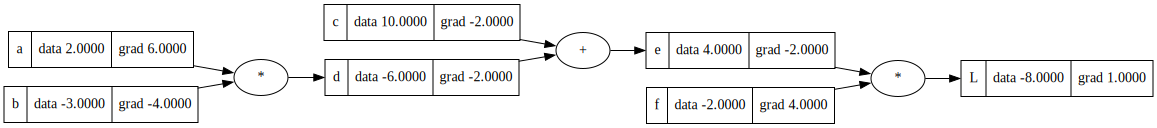

In [36]:
draw_dot(L)

## Derivatives by hand:

d(L)/dL = 1 * L^0 = 1.0

L = e * f = e^1 * f = e * f^1  

d(L)/de = 1 * e^0 * f = f = -2.0  
d(L)/df = e * 1 * f^0 = e = 4.0  

## Backpropagation > Chain rule

e = d + c

#### local derivates:  
d(e)/dd = 1.0  
d(e)/dc = 1.0  

#### chain rule:
d(L)/dd = d(L)/de * d(e)/dd = -2.0 * 1.0 = -2.0  
d(L)/dc = d(L)/de * d(e)/dc = -2.0 * 1.0 = -2.0  


d = a * b

#### local derivates:  
d(d)/da = b = -3.0  
d(d)/db = a = 2.0

#### chain rule:
d(L)/da = d(L)/de * d(e)/dd * d(d)/da = -2.0 * 1.0 * -3.0 = 6.0  
d(L)/db = d(L)/de * d(e)/dd * d(d)/db = -2.0 * 1.0 * 2.0 = -4.0  

## With other words

a.grad = b.data * d.grad  
b.grad = a.data * d.grad  
c.grad = e.grad  
d.grad = e.grad  
e.grad = L.grad * f.data  
f.grad = L.grad * e.data  
L.grad = 1.0  
